<div style="text-align: right">Group 4: <br> </div>
<div style="text-align: right">Viswanath Raju Indukuri <br> </div>
<div style="text-align: right">Arnab Chakraborty <br> </div>

--------------------------------------------------------------------------------------------

# Final Project: INFO6106 Neural Modeling Methods & Tools



# Lake Effect Precipitation Prediction using CNN and RNN

(1 day in Advance)

**Import necessary libraries**

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import date

import pickle
import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
import tensorflow as tf

In [4]:
print(tf.__version__)

2.16.1


In [5]:
from keras.models import Model
from keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

## Read `meteorological_data` data

In [6]:
meteorological_data_original = pd.read_csv('meteorological_data.csv')

meteorological_data_full = meteorological_data_original.copy()
meteorological_data_full

,DateTime_UTC,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in
0,2006-10-01 00:00:00,48.0,86.0,7,150,4100,10,984.0,0.00
1,2006-10-01 01:00:00,48.0,86.0,8,150,6000,10,983.7,0.00
2,2006-10-01 02:00:00,48.0,86.0,6,150,5500,10,982.7,0.00
3,2006-10-01 03:00:00,48.0,86.0,8,150,6000,10,982.0,0.00
4,2006-10-01 04:00:00,48.0,89.0,5,150,2200,8,982.0,0.02
...,...,...,...,...,...,...,...,...,...
48116,2017-03-31 19:00:00,40.0,76.0,0,0,5000,10,991.7,0.00
48117,2017-03-31 20:00:00,39.0,72.0,3,20,5000,10,992.3,0.00
48118,2017-03-31 21:00:00,35.0,84.0,5,300,5000,10,993.3,0.00
48119,2017-03-31 22:00:00,34.0,85.0,0,0,5000,10,993.3,0.00


**Convert `DateTime_UTC` to Datetime format**

In [7]:
meteorological_data_full['DateTime_UTC'] = pd.to_datetime(meteorological_data_full['DateTime_UTC'], format='%Y-%m-%d %H:%M:%S')

**Resample Hourly Meteorological Data to Daily Averages and Sums**

In [8]:
# Resample hourly data into daily data
daily_data = meteorological_data_full.groupby(meteorological_data_full['DateTime_UTC'].dt.date).agg({
   'Temp_F': 'mean',    
    'RH_pct': 'mean',    
    'Wind_Spd_mph': 'mean',     
    'Atm_Press_hPa': 'mean',
    'Low_Cloud_Ht_ft': 'mean',
    'Visibility_mi': 'mean',    
    'Precip_in': 'sum',     
}).reset_index()

In [9]:
daily_data.dtypes

DateTime_UTC        object
Temp_F             float64
RH_pct             float64
Wind_Spd_mph       float64
Atm_Press_hPa      float64
Low_Cloud_Ht_ft    float64
Visibility_mi      float64
Precip_in          float64
dtype: object

In [10]:
daily_data

,DateTime_UTC,Temp_F,RH_pct,Wind_Spd_mph,Atm_Press_hPa,Low_Cloud_Ht_ft,Visibility_mi,Precip_in
0,2006-10-01,51.500000,74.958333,5.166667,991.275000,4683.333333,9.833333,0.03
1,2006-10-02,62.750000,73.166667,5.250000,990.054167,3450.000000,9.166667,0.01
2,2006-10-03,59.875000,81.458333,4.875000,993.491667,3595.833333,7.250000,2.02
3,2006-10-04,55.625000,72.041667,9.833333,997.937500,1908.333333,9.875000,0.01
4,2006-10-05,49.208333,75.791667,5.083333,1002.075000,1783.333333,7.833333,0.56
...,...,...,...,...,...,...,...,...
2000,2017-03-27,38.250000,88.250000,4.750000,991.920833,808.333333,8.166667,0.03
2001,2017-03-28,38.833333,86.041667,4.666667,995.729167,7187.500000,6.750000,0.00
2002,2017-03-29,37.458333,77.708333,4.750000,1000.233333,6237.500000,8.208333,0.00
2003,2017-03-30,36.291667,78.041667,7.458333,993.387500,2866.666667,8.375000,0.10


### **Assign 3rd next Day's Precipitation to current days features to predict Two Days in advance**

adds a new column `Precip_next`. This column represents the precipitation value of the next day by shifting the `Precip_in` column upwards by one row.

In [11]:
daily_data['Precip_next']=daily_data['Precip_in'].shift(-1)

daily_data.dropna(subset=['Precip_next'],inplace=True)

In [12]:
daily_data

,DateTime_UTC,Temp_F,RH_pct,Wind_Spd_mph,Atm_Press_hPa,Low_Cloud_Ht_ft,Visibility_mi,Precip_in,Precip_next
0,2006-10-01,51.500000,74.958333,5.166667,991.275000,4683.333333,9.833333,0.03,0.01
1,2006-10-02,62.750000,73.166667,5.250000,990.054167,3450.000000,9.166667,0.01,2.02
2,2006-10-03,59.875000,81.458333,4.875000,993.491667,3595.833333,7.250000,2.02,0.01
3,2006-10-04,55.625000,72.041667,9.833333,997.937500,1908.333333,9.875000,0.01,0.56
4,2006-10-05,49.208333,75.791667,5.083333,1002.075000,1783.333333,7.833333,0.56,0.00
...,...,...,...,...,...,...,...,...,...
1999,2017-03-26,41.666667,89.625000,4.250000,991.770833,950.000000,6.875000,0.09,0.03
2000,2017-03-27,38.250000,88.250000,4.750000,991.920833,808.333333,8.166667,0.03,0.00
2001,2017-03-28,38.833333,86.041667,4.666667,995.729167,7187.500000,6.750000,0.00,0.00
2002,2017-03-29,37.458333,77.708333,4.750000,1000.233333,6237.500000,8.208333,0.00,0.10


**We need to remove March 30th & 31st for every year because when we shifted the precipitation values, it took on the value of October 1st and 2nd, which is not desired.**

In [13]:
year_list = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
remove_dates = []
for y in year_list:
    # Create date objects for March 31st and March 30th
    mar_31 = date(y, 3, 31)
    
    # Append dates to the list
    remove_dates.append(mar_31)

# Print the list of dates to be removed
remove_dates

[datetime.date(2006, 3, 31),
 datetime.date(2007, 3, 31),
 datetime.date(2008, 3, 31),
 datetime.date(2009, 3, 31),
 datetime.date(2010, 3, 31),
 datetime.date(2011, 3, 31),
 datetime.date(2012, 3, 31),
 datetime.date(2013, 3, 31),
 datetime.date(2014, 3, 31),
 datetime.date(2015, 3, 31),
 datetime.date(2016, 3, 31),
 datetime.date(2017, 3, 31)]

In [14]:
daily_data = daily_data[~daily_data['DateTime_UTC'].isin(remove_dates)].reset_index(drop=True)
daily_data

,DateTime_UTC,Temp_F,RH_pct,Wind_Spd_mph,Atm_Press_hPa,Low_Cloud_Ht_ft,Visibility_mi,Precip_in,Precip_next
0,2006-10-01,51.500000,74.958333,5.166667,991.275000,4683.333333,9.833333,0.03,0.01
1,2006-10-02,62.750000,73.166667,5.250000,990.054167,3450.000000,9.166667,0.01,2.02
2,2006-10-03,59.875000,81.458333,4.875000,993.491667,3595.833333,7.250000,2.02,0.01
3,2006-10-04,55.625000,72.041667,9.833333,997.937500,1908.333333,9.875000,0.01,0.56
4,2006-10-05,49.208333,75.791667,5.083333,1002.075000,1783.333333,7.833333,0.56,0.00
...,...,...,...,...,...,...,...,...,...
1989,2017-03-26,41.666667,89.625000,4.250000,991.770833,950.000000,6.875000,0.09,0.03
1990,2017-03-27,38.250000,88.250000,4.750000,991.920833,808.333333,8.166667,0.03,0.00
1991,2017-03-28,38.833333,86.041667,4.666667,995.729167,7187.500000,6.750000,0.00,0.00
1992,2017-03-29,37.458333,77.708333,4.750000,1000.233333,6237.500000,8.208333,0.00,0.10


**Min, Max and Mean Precipitation values**

In [15]:
mean_precip = daily_data['Precip_in'].mean()
min_precip = daily_data['Precip_in'].min()
max_precip = daily_data['Precip_in'].max()

print("Mean precipitation:", mean_precip)
print("Minimum precipitation:", min_precip)
print("Maximum precipitation:", max_precip)

Mean precipitation: 0.060431293881644935
Minimum precipitation: 0.0
Maximum precipitation: 2.02


**Categorizing Precipitation Data**

Categorize precipitation data into different levels ('No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain')

In [16]:
# Define conditions based on real scenarios
conditions = [
    (daily_data['Precip_next'] == 0),
    (daily_data['Precip_next'] > 0) & (daily_data['Precip_next'] <= 0.1),
    (daily_data['Precip_next'] > 0.1) & (daily_data['Precip_next'] <= 0.3),
    (daily_data['Precip_next'] > 0.3)
]

# Define corresponding labels for each condition
names = ['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain']

# Replace values in 'target' column with corresponding labels based on conditions 
daily_data['target'] = np.select(conditions, names, default='')
daily_data.head()

,DateTime_UTC,Temp_F,RH_pct,Wind_Spd_mph,Atm_Press_hPa,Low_Cloud_Ht_ft,Visibility_mi,Precip_in,Precip_next,target
0,2006-10-01,51.500000,74.958333,5.166667,991.275000,4683.333333,9.833333,0.03,0.01,Light Rain
1,2006-10-02,62.750000,73.166667,5.250000,990.054167,3450.000000,9.166667,0.01,2.02,Heavy Rain
2,2006-10-03,59.875000,81.458333,4.875000,993.491667,3595.833333,7.250000,2.02,0.01,Light Rain
3,2006-10-04,55.625000,72.041667,9.833333,997.937500,1908.333333,9.875000,0.01,0.56,Heavy Rain
4,2006-10-05,49.208333,75.791667,5.083333,1002.075000,1783.333333,7.833333,0.56,0.00,No Rain


**Class distribution in the `target` column after categorization**

In [17]:
print(daily_data['target'].value_counts())

target
No Rain          1052
Light Rain        636
Moderate Rain     198
Heavy Rain        108
Name: count, dtype: int64


**One-Hot Encoding the Target Column**

In [18]:
# Perform one-hot encoding directly on the DataFrame with specified categories order
one_hot_encoded = pd.get_dummies(daily_data['target'], prefix='', prefix_sep='').reindex(columns=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain'], fill_value=0)

# Convert the data type to integer
one_hot_encoded = one_hot_encoded.astype(int)

# Concatenate the one-hot encoded columns to the DataFrame
daily_data = pd.concat([daily_data, one_hot_encoded], axis=1)

# Display the updated DataFrame
daily_data.head()

,DateTime_UTC,Temp_F,RH_pct,Wind_Spd_mph,Atm_Press_hPa,Low_Cloud_Ht_ft,Visibility_mi,Precip_in,Precip_next,target,No Rain,Light Rain,Moderate Rain,Heavy Rain
0,2006-10-01,51.500000,74.958333,5.166667,991.275000,4683.333333,9.833333,0.03,0.01,Light Rain,0,1,0,0
1,2006-10-02,62.750000,73.166667,5.250000,990.054167,3450.000000,9.166667,0.01,2.02,Heavy Rain,0,0,0,1
2,2006-10-03,59.875000,81.458333,4.875000,993.491667,3595.833333,7.250000,2.02,0.01,Light Rain,0,1,0,0
3,2006-10-04,55.625000,72.041667,9.833333,997.937500,1908.333333,9.875000,0.01,0.56,Heavy Rain,0,0,0,1
4,2006-10-05,49.208333,75.791667,5.083333,1002.075000,1783.333333,7.833333,0.56,0.00,No Rain,1,0,0,0


**Dividing the meteorological data to `features` and `lables`**

In [19]:
features = daily_data.columns[1:8]
features

Index(['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Atm_Press_hPa', 'Low_Cloud_Ht_ft',
       'Visibility_mi', 'Precip_in'],
      dtype='object')

In [20]:
labels = daily_data.columns[-4:]
labels

Index(['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain'], dtype='object')

------

## Scale the features

In [21]:
# Convert 'DateTime_UTC' column to datetime type
daily_data['DateTime_UTC'] = pd.to_datetime(daily_data['DateTime_UTC'])

# Define scaler
scaler = MinMaxScaler()

# Scale data for October 2006 to March 2016
mask_2006_to_2016 = (daily_data['DateTime_UTC'] >= '2006-10-01') & (daily_data['DateTime_UTC'] < '2016-04-01')
daily_data.loc[mask_2006_to_2016, ['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Atm_Press_hPa', 'Low_Cloud_Ht_ft', 'Visibility_mi', 'Precip_in']] = scaler.fit_transform(daily_data.loc[mask_2006_to_2016, ['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Atm_Press_hPa', 'Low_Cloud_Ht_ft', 'Visibility_mi', 'Precip_in']])

# Scale data for October 2016 to March 2017
mask_2016_to_2017 = (daily_data['DateTime_UTC'] >= '2016-10-01') & (daily_data['DateTime_UTC'] < '2017-04-01')
daily_data.loc[mask_2016_to_2017, ['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Atm_Press_hPa', 'Low_Cloud_Ht_ft', 'Visibility_mi', 'Precip_in']] = scaler.fit_transform(daily_data.loc[mask_2016_to_2017, ['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Atm_Press_hPa', 'Low_Cloud_Ht_ft', 'Visibility_mi', 'Precip_in']])

daily_data['Date'] = daily_data['DateTime_UTC'].dt.date

# Print the scaled DataFrame
daily_data

,DateTime_UTC,Temp_F,RH_pct,Wind_Spd_mph,Atm_Press_hPa,Low_Cloud_Ht_ft,Visibility_mi,Precip_in,Precip_next,target,No Rain,Light Rain,Moderate Rain,Heavy Rain,Date
0,2006-10-01,0.671649,0.695153,0.256351,0.556518,0.187333,0.981043,0.014851,0.01,Light Rain,0,1,0,0,2006-10-01
1,2006-10-02,0.810825,0.667730,0.260970,0.528941,0.138000,0.905213,0.004950,2.02,Heavy Rain,0,0,0,1,2006-10-02
2,2006-10-03,0.775258,0.794643,0.240185,0.606588,0.143833,0.687204,1.000000,0.01,Light Rain,0,1,0,0,2006-10-03
3,2006-10-04,0.722680,0.650510,0.515012,0.707012,0.076333,0.985782,0.004950,0.56,Heavy Rain,0,0,0,1,2006-10-04
4,2006-10-05,0.643299,0.707908,0.251732,0.800471,0.071333,0.753555,0.277228,0.00,No Rain,1,0,0,0,2006-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,2017-03-26,0.529412,0.893727,0.179167,0.495098,0.023814,0.634146,0.116883,0.03,Light Rain,0,1,0,0,2017-03-26
1990,2017-03-27,0.470588,0.869373,0.204167,0.499202,0.017633,0.785366,0.038961,0.00,No Rain,1,0,0,0,2017-03-27
1991,2017-03-28,0.480631,0.830258,0.200000,0.603397,0.295946,0.619512,0.000000,0.00,No Rain,1,0,0,0,2017-03-28
1992,2017-03-29,0.456958,0.682657,0.204167,0.726630,0.254499,0.790244,0.000000,0.10,Light Rain,0,1,0,0,2017-03-29


---------

## Read `filtered_les_cld_imgs` data

In [22]:
img_data_original = pd.read_csv('filtered_les_cld_imgs.csv')

img_data = img_data_original.copy()
img_data.head()

,DateTime_UTC,Lake_data_2D
0,2006-10-01 14:00:00,"[array([ nan, nan, nan, ..."
1,2006-10-01 15:00:00,"[array([ nan, nan, nan, ..."
2,2006-10-01 16:00:00,"[array([ nan, nan, nan, nan, nan..."
3,2006-10-01 17:00:00,"[array([ nan, nan, nan, nan, nan, nan, n..."
4,2006-10-01 18:00:00,"[array([ nan, nan, nan, nan, nan..."


**Convert `DateTime_UTC` to Datetime format**

In [23]:
img_data['DateTime_UTC'] = pd.to_datetime(img_data['DateTime_UTC'], format='%Y-%m-%d %H:%M:%S')

In [24]:
img_data['Date'] = img_data['DateTime_UTC'].dt.date
img_data.head()

,DateTime_UTC,Lake_data_2D,Date
0,2006-10-01 14:00:00,"[array([ nan, nan, nan, ...",2006-10-01
1,2006-10-01 15:00:00,"[array([ nan, nan, nan, ...",2006-10-01
2,2006-10-01 16:00:00,"[array([ nan, nan, nan, nan, nan...",2006-10-01
3,2006-10-01 17:00:00,"[array([ nan, nan, nan, nan, nan, nan, n...",2006-10-01
4,2006-10-01 18:00:00,"[array([ nan, nan, nan, nan, nan...",2006-10-01


----

### Creating the Training Data Sequences of Cloud images and meteorological data

In [25]:
sequence_length = 7
year_list = [2006,2007,2008,2009,2012,2013,2014,2015]

In [26]:
img_data['Date'] = img_data['DateTime_UTC'].dt.date

In [27]:
all_meteo_seq_list = []
all_label_list = []
all_video_list = []

for y in tqdm(year_list):
    start_date = date(y, 10, 1)
    end_date = date(y+1, 3, 31)

    train_meteo_data = daily_data[(daily_data['Date']>=start_date)
                                  &(daily_data['Date']<=end_date)].reset_index(drop=True) 
    
    train_img_data = img_data[(img_data['Date']>=start_date)
                             &(img_data['Date']<=end_date)]

    meteo_seq_list = []
    label_list = []
    date_list = []
    video_list = []

    for i in range(sequence_length-1, len(train_meteo_data)):

        meteo_seq = train_meteo_data[i - (sequence_length-1) : i+1][features].values
        label = train_meteo_data[labels].values[i]
        curr_date = train_meteo_data['Date'].values[i]

        meteo_seq_list.append(meteo_seq)
        label_list.append(label)
        date_list.append(curr_date)

        curr_img_data = train_img_data[train_img_data.Date == curr_date]
        image_list=[]

        for i in range(len(curr_img_data)):
            data_sample_2d = curr_img_data['Lake_data_2D'].values[i]
            data_sample_2d_array = np.array(eval(data_sample_2d.replace('array(', '').replace('nan', 'np.nan').replace('\n', '').replace(')', '')))
            data_sample_2d_array_resized = cv2.resize(data_sample_2d_array, (64, 64))
            data_sample_2d_array_resized = np.expand_dims(data_sample_2d_array_resized, axis=-1)
            image_list.append(data_sample_2d_array_resized)

        array_3d = np.stack(image_list, axis=0)
        array_3d_filled = np.nan_to_num(array_3d, nan=0.0)
        video_list.append(array_3d_filled)
            
    meteo_seq_array = np.stack(meteo_seq_list, axis=0)    
    label_array = np.stack(label_list, axis=0)
    video_array = np.stack(video_list, axis=0)
    
    all_meteo_seq_list.append(meteo_seq_array)
    all_label_list.append(label_array)
    all_video_list.append(video_array)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:42<00:00, 27.84s/it]


In [28]:
train_meteo = np.concatenate(all_meteo_seq_list, axis=0)
train_video = np.concatenate(all_video_list, axis=0)
train_label = np.concatenate(all_label_list, axis=0)

In [29]:
train_meteo.shape, train_video.shape, train_label.shape

((1402, 7, 7), (1402, 9, 64, 64, 1), (1402, 4))

### Creating the Testing Data Sequences of Cloud images and meteorological data

In [30]:
sequence_length = 7
year_list = [2016]

In [31]:
all_meteo_seq_list = []
all_label_list = []
all_video_list = []

for y in tqdm(year_list):
    start_date = date(y, 10, 1)
    end_date = date(y+1, 3, 31)

    train_meteo_data = daily_data[(daily_data['Date']>=start_date)
                                  &(daily_data['Date']<=end_date)].reset_index(drop=True) 
    
    train_img_data = img_data[(img_data['Date']>=start_date)
                             &(img_data['Date']<=end_date)]

    meteo_seq_list = []
    label_list = []
    date_list = []
    video_list = []

    for i in range(sequence_length-1, len(train_meteo_data)):

        meteo_seq = train_meteo_data[i - (sequence_length-1) : i+1][features].values
        label = train_meteo_data[labels].values[i]
        curr_date = train_meteo_data['Date'].values[i]

        meteo_seq_list.append(meteo_seq)
        label_list.append(label)
        date_list.append(curr_date)

        curr_img_data = train_img_data[train_img_data.Date == curr_date]
        image_list=[]

        for i in range(len(curr_img_data)):
            data_sample_2d = curr_img_data['Lake_data_2D'].values[i]
            data_sample_2d_array = np.array(eval(data_sample_2d.replace('array(', '').replace('nan', 'np.nan').replace('\n', '').replace(')', '')))
            data_sample_2d_array_resized = cv2.resize(data_sample_2d_array, (64, 64))
            data_sample_2d_array_resized = np.expand_dims(data_sample_2d_array_resized, axis=-1)
            image_list.append(data_sample_2d_array_resized)

        array_3d = np.stack(image_list, axis=0)
        array_3d_filled = np.nan_to_num(array_3d, nan=0.0)
        video_list.append(array_3d_filled)
            
    meteo_seq_array = np.stack(meteo_seq_list, axis=0)    
    label_array = np.stack(label_list, axis=0)
    video_array = np.stack(video_list, axis=0)
    
    all_meteo_seq_list.append(meteo_seq_array)
    all_label_list.append(label_array)
    all_video_list.append(video_array)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.12s/it]


In [32]:
test_meteo = np.concatenate(all_meteo_seq_list, axis=0)
test_video = np.concatenate(all_video_list, axis=0)
test_label = np.concatenate(all_label_list, axis=0)

In [33]:
test_meteo.shape, test_video.shape, test_label.shape

((175, 7, 7), (175, 9, 64, 64, 1), (175, 4))

---


# Convolutional Neural Network + Recurrent Neural Network Architecture

## Hybrid Model 1

**To balance the weights and pay more attention to underrepresented classes, we will calculate the class weights and pass this during training**

In [34]:
category_counts = one_hot_encoded.sum()

total_samples = one_hot_encoded.sum().sum()

class_weights = total_samples / (4 * category_counts)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [35]:
class_weight_dict

{0: 0.4738593155893536,
 1: 0.7838050314465409,
 2: 2.5176767676767677,
 3: 4.6157407407407405}

Model Architecture
- One CNN layer
- Three RNN LSTM layers, with verying units throughout the layers and activations as desired
- BatchNormalization for each layers

In [36]:
# CNN Model
cnn_input = Input(shape=(9, 64, 64, 1))
cnn = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(cnn_input)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)

cnn = Flatten()(cnn)
cnn_output = Dense(32, activation='relu')(cnn)

# RNN Model
rnn_input = Input(shape=(7, 7))
rnn = LSTM(128, return_sequences=True)(rnn_input)
rnn = BatchNormalization()(rnn)
rnn = LSTM(64, return_sequences=True)(rnn)
rnn = BatchNormalization()(rnn)
rnn = LSTM(32, return_sequences=False)(rnn)
rnn = BatchNormalization()(rnn)
rnn_output = Dense(24, activation='relu')(rnn)

# Concatenation and final layers
concatenated = Concatenate()([cnn_output, rnn_output])

final_dense = Dense(32, activation='relu')(concatenated)
final_output = Dense(4, activation='softmax')(final_dense)

# Final model assembly
model = Model(inputs=[cnn_input, rnn_input], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 7, 7)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 7, 128)            │          69,632 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer (InputLayer)      │ (None, 9, 64, 64, 1)      │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 7, 128)            │             512 │ lstm[0][0]                 │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 9, 64, 64, 32)     │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 7, 64)             │          49,408 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 9, 64, 64, 32)     │             128 │ conv3d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 7, 64)             │             256 │ lstm_1[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 4, 32, 32, 32)     │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 32)                │          12,416 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 131072)            │               0 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 32)                │             128 │ lstm_2[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │       4,194,336 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 24)                │             792 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 56)                │               0 │ dense[0][0], dense_1[0][0] │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,330,460 (16.52 MB)

 Trainable params: 4,329,948 (16.52 MB)

 Non-trainable params: 512 (2.00 KB)

**Model Fitting**

In [38]:
history = model.fit(
    [train_video, train_meteo],
    train_label,                
    epochs=30,                 
    batch_size=32,               
    class_weight=class_weight_dict,
    validation_split=0.2
)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.2775 - loss: 9.6940 - val_accuracy: 0.2669 - val_loss: 1.3769
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.2591 - loss: 1.9065 - val_accuracy: 0.4164 - val_loss: 1.3665
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.3475 - loss: 1.3507 - val_accuracy: 0.5730 - val_loss: 1.3179
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.4177 - loss: 1.2963 - val_accuracy: 0.4733 - val_loss: 1.3569
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 357ms/step - accuracy: 0.3190 - loss: 1.3002 - val_accuracy: 0.5801 - val_loss: 1.3240
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - accuracy: 0.4304 - loss: 1.2065 - val_accuracy: 0.5445 - val_loss: 1.2720
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.4414 - loss: 1.2021 - val_accuracy: 0.5694 - val_loss: 1.2754
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.4536 - loss: 1.1072 - val_accu

**Plots for training & validation accuracy & loss values**

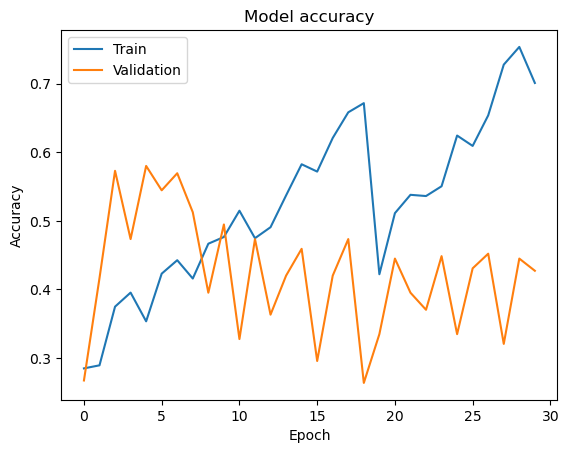

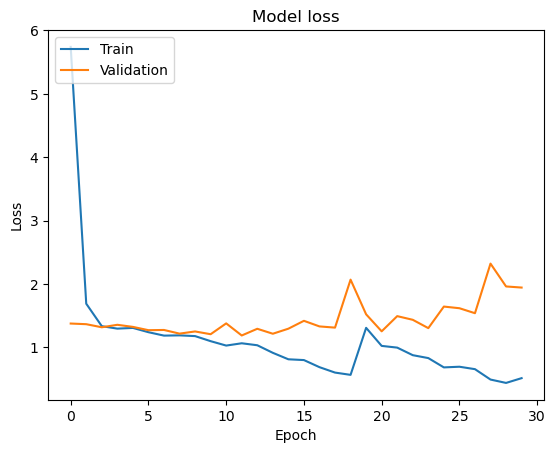

In [39]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on the test data**

In [40]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([test_video, test_meteo], test_label)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3824 - loss: 2.0263
Test Loss: 1.9669239521026611
Test Accuracy: 0.4114285707473755


**Prediction on the test dataset**

In [41]:
# Predict the test dataset
pred_label = model.predict([test_video, test_meteo])

# Convert predictions from one-hot to labels
pred_label_cat = np.argmax(pred_label, axis=1)
true_label_cat = np.argmax(test_label, axis=1)

print(classification_report(true_label_cat.flatten(), pred_label_cat.flatten()))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
              precision    recall  f1-score   support

           0       0.62      0.43      0.51        91
           1       0.33      0.47      0.39        60
           2       0.14      0.19      0.16        16
           3       0.29      0.25      0.27         8

    accuracy                           0.41       175
   macro avg       0.35      0.33      0.33       175
weighted avg       0.46      0.41      0.42       175



**Confusion Matrix**

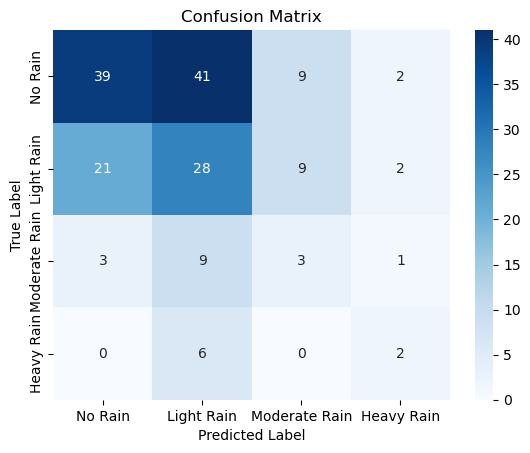

In [42]:
conmat = confusion_matrix(true_label_cat.flatten(), pred_label_cat.flatten())
sns.heatmap(conmat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

-----

## Hybrid Model 2

Model Architecture
- One CNN layer
- Three RNN LSTM layers, with verying units through out layers and activations as desired
- Also, added dropouts and BatchNormalization

In [43]:
# Define CNN input
cnn_input = Input(shape=(9, 64, 64, 1))

# CNN Model
cnn = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(cnn_input)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)
cnn = Dropout(0.20)(cnn)
cnn = Flatten()(cnn)
cnn_output = Dense(32, activation='relu')(cnn)

# Define RNN input
rnn_input = Input(shape=(7, 7))

# RNN Model
rnn = LSTM(128, return_sequences=True, activation='relu')(rnn_input)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.30)(rnn)
rnn = LSTM(64, return_sequences=True, activation='relu')(rnn)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.20)(rnn)
rnn = LSTM(32, return_sequences=False, activation='relu')(rnn)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.10)(rnn)
rnn_output = Dense(24, activation='relu')(rnn)

# Concatenate CNN and RNN outputs
concatenated = Concatenate()([cnn_output, rnn_output])

# Final dense layers
final_dense = Dense(32, activation='relu')(concatenated)
final_output = Dense(4, activation='softmax')(final_dense)

# Model assembly
model = Model(inputs=[cnn_input, rnn_input], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 7, 7)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 7, 128)            │          69,632 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_5         │ (None, 7, 128)            │             512 │ lstm_3[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 7, 128)            │               0 │ batch_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 9, 64, 64, 1)      │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ (None, 7, 64)             │          49,408 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 9, 64, 64, 32)     │             896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 7, 64)             │             256 │ lstm_4[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 9, 64, 64, 32)     │             128 │ conv3d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 7, 64)             │               0 │ batch_normalization_6[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 4, 32, 32, 32)     │               0 │ batch_normalization_4[0][… │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ (None, 32)                │          12,416 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 4, 32, 32, 32)     │               0 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 32)                │             128 │ lstm_5[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 131072)            │               

 Total params: 4,330,460 (16.52 MB)

 Trainable params: 4,329,948 (16.52 MB)

 Non-trainable params: 512 (2.00 KB)

**Model Fitting**

In [45]:
history = model.fit(
    [train_video, train_meteo],
    train_label,                
    epochs=30,                 
    batch_size=32,               
    class_weight=class_weight_dict,
    validation_split=0.3
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - accuracy: 0.1830 - loss: 9.0209 - val_accuracy: 0.3112 - val_loss: 1.3303
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.3089 - loss: 1.8435 - val_accuracy: 0.1829 - val_loss: 1.4025
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.3559 - loss: 1.4056 - val_accuracy: 0.0855 - val_loss: 1.4147
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.3142 - loss: 1.4089 - val_accuracy: 0.0523 - val_loss: 1.4296
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.2359 - loss: 1.5545 - val_accuracy: 0.3824 - val_loss: 1.3788
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - accuracy: 0.3752 - loss: 1.3545 - val_accuracy: 0.2589 - val_loss: 1.3912
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 506ms/step - accuracy: 0.3571 - loss: 1.4386 - val_accuracy: 0.4964 - val_loss: 1.3568
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step - accuracy: 0.4181 - loss: 1.2324 - val_accu

**Plots for training & validation accuracy & loss values**

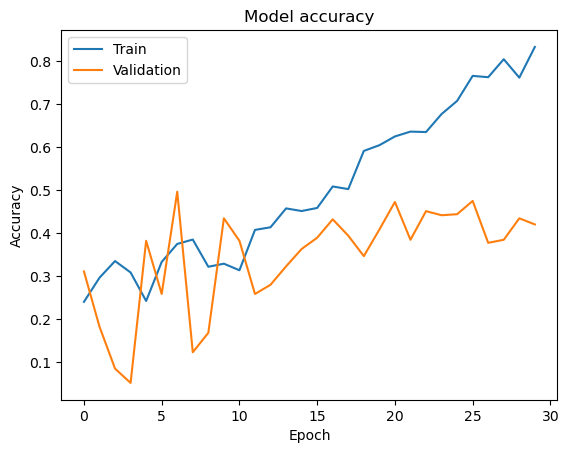

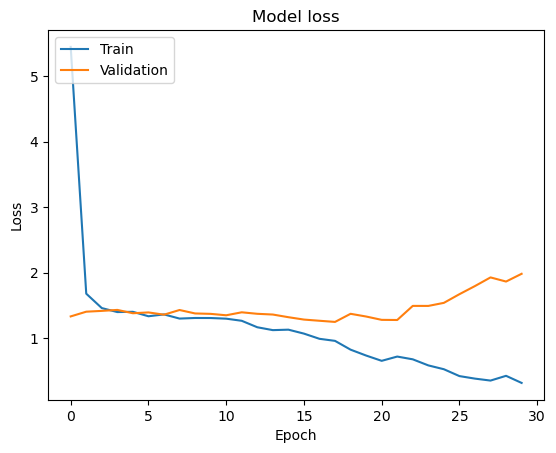

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on the test data**

In [47]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([test_video, test_meteo], test_label)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4245 - loss: 2.2913
Test Loss: 2.185062885284424
Test Accuracy: 0.4114285707473755


**Prediction on the test dataset**

In [48]:
# Predict the test dataset
pred_label = model.predict([test_video, test_meteo])

# Convert predictions from one-hot to labels
pred_label_cat = np.argmax(pred_label, axis=1)
true_label_cat = np.argmax(test_label, axis=1)

print(classification_report(true_label_cat.flatten(), pred_label_cat.flatten()))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
              precision    recall  f1-score   support

           0       0.59      0.41      0.48        91
           1       0.41      0.50      0.45        60
           2       0.15      0.25      0.19        16
           3       0.08      0.12      0.10         8

    accuracy                           0.41       175
   macro avg       0.31      0.32      0.30       175
weighted avg       0.46      0.41      0.43       175



**Confusion Matrix**

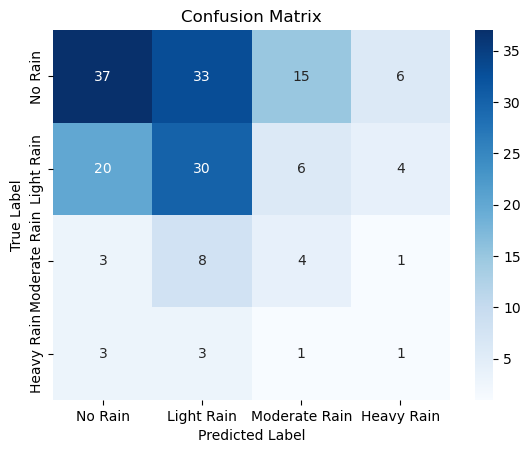

In [49]:
conmat = confusion_matrix(true_label_cat.flatten(), pred_label_cat.flatten())
sns.heatmap(conmat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

-----

# Hybrid Model 3

Model Architecture
- One CNN layer
- Two RNN LSTM layers, with verying units through out layers and activations as desired
- BatchNormalization and no dropouts this time

In [50]:
# CNN Model
cnn_input = Input(shape=(9, 64, 64, 1))
cnn = Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same')(cnn_input)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)

cnn = Flatten()(cnn)
cnn_output = Dense(16, activation='relu')(cnn)

# RNN Model
rnn_input = Input(shape=(7, 7))
rnn = LSTM(64, return_sequences=True)(rnn_input)
rnn = BatchNormalization()(rnn)
rnn = LSTM(32, return_sequences=False)(rnn)
rnn = BatchNormalization()(rnn)
rnn_output = Dense(24, activation='relu')(rnn)

# Concatenation and final layers
concatenated = Concatenate()([cnn_output, rnn_output])

final_dense = Dense(32, activation='relu')(concatenated)
final_output = Dense(4, activation='softmax')(final_dense)

# Final model assembly
model = Model(inputs=[cnn_input, rnn_input], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 9, 64, 64, 1)      │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 7, 7)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 9, 64, 64, 32)     │             896 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_6 (LSTM)                 │ (None, 7, 64)             │          18,432 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 9, 64, 64, 32)     │             128 │ conv3d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 7, 64)             │             256 │ lstm_6[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 4, 32, 32, 32)     │               0 │ batch_normalization_8[0][… │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_7 (LSTM)                 │ (None, 32)                │          12,416 │ batch_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 131072)            │               0 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 32)                │             128 │ lstm_7[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 16)                │       2,097,168 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 24)                │             792 │ batch_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 40)                │               0 │ dense_8[0][0],             │
│                               │                           │                 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 32)                │           1,312 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 4)                 │             13

 Total params: 2,131,660 (8.13 MB)

 Trainable params: 2,131,404 (8.13 MB)

 Non-trainable params: 256 (1.00 KB)

**Model Fitting**

In [52]:
history = model.fit(
    [train_video, train_meteo],
    train_label,                
    epochs=50,                 
    batch_size=32,               
    class_weight=class_weight_dict,
    validation_split=0.2
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.3017 - loss: 8.9038 - val_accuracy: 0.5409 - val_loss: 1.3756
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.3296 - loss: 1.3188 - val_accuracy: 0.2633 - val_loss: 1.3722
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.3688 - loss: 1.3198 - val_accuracy: 0.2491 - val_loss: 1.3739
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.3936 - loss: 1.2369 - val_accuracy: 0.2491 - val_loss: 1.3788
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.3622 - loss: 1.2489 - val_accuracy: 0.2491 - val_loss: 1.3559
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.3869 - loss: 1.2105 - val_accuracy: 0.2705 - val_loss: 1.3223
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.4234 - loss: 1.2019 - val_accuracy: 0.2420 - val_loss: 1.3301
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.4291 - loss: 1.1614 - val_accu

**Plots for training & validation accuracy & loss values**

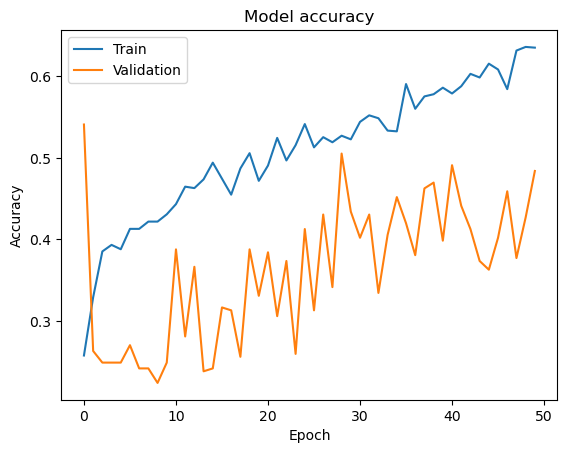

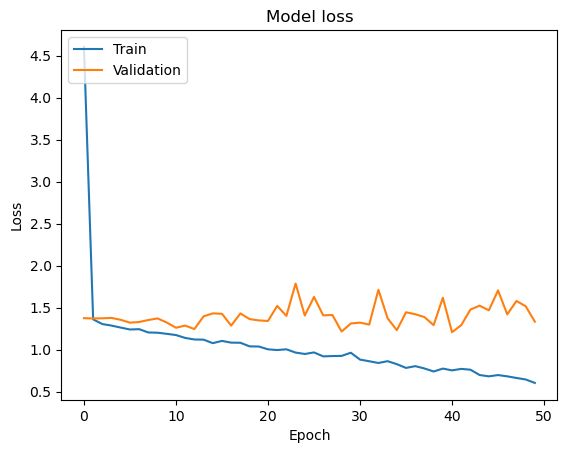

In [53]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on the test data**

In [54]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([test_video, test_meteo], test_label)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3456 - loss: 1.7903
Test Loss: 1.8831700086593628
Test Accuracy: 0.35428571701049805


**Prediction on the test dataset**

In [55]:
# Predict the test dataset
pred_label = model.predict([test_video, test_meteo])

# Convert predictions from one-hot to labels
pred_label_cat = np.argmax(pred_label, axis=1)
true_label_cat = np.argmax(test_label, axis=1)

print(classification_report(true_label_cat.flatten(), pred_label_cat.flatten()))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
              precision    recall  f1-score   support

           0       0.53      0.48      0.51        91
           1       0.32      0.27      0.29        60
           2       0.06      0.12      0.08        16
           3       0.00      0.00      0.00         8

    accuracy                           0.35       175
   macro avg       0.23      0.22      0.22       175
weighted avg       0.39      0.35      0.37       175



**Confusion Matrix**

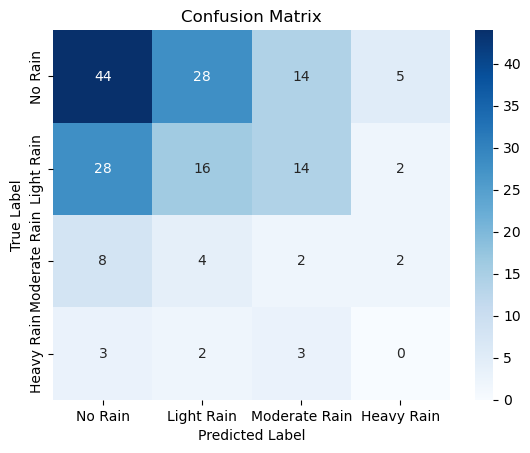

In [56]:
conmat = confusion_matrix(true_label_cat.flatten(), pred_label_cat.flatten())
sns.heatmap(conmat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

-----

## Conclusion:
**The hybrid model 2 with One CNN layer and 3 RNN LSTM worked well to predict one day in advance covering all four classes, although the accuracies are not that great because of less data after doing aggregations in daily level**